# Simulation

In this tutorial, you are going to simulate the spread of COVID-19 for an artificial
data set. First, some imports

In [383]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sid import simulate


N_INDIVIDUALS = 10_000
N_INFECTIOUS = 100
N_PERIODS = 200

index_cols = ["category", "subcategory", "name"]

At first, we are loading some pre-defined parameters.

In [384]:
params = pd.read_csv("../../../sid/params.csv", index_col=index_cols)

Next, simulate some data on individuals which have two characteristics, an age group and
a country they live in.

In [385]:
age_group = np.random.choice(
    [
        "0 - 9",
        "10 - 19",
        "20 - 29",
        "30 - 39",
        "40 - 49",
        "50 - 59",
        "60 - 69",
        "70 - 79",
        "80 - 100",
    ],
    size=N_INDIVIDUALS,
)
region = np.random.choice(["Drenthe", "Gelderland", "Overtjssel"], size=N_INDIVIDUALS)

initial_states = pd.DataFrame({
    "age_group": age_group, 
    "region": region})
initial_states.head(5)

,age_group,region
0,60 - 69,Gelderland
1,0 - 9,Overtjssel
2,40 - 49,Gelderland
3,50 - 59,Overtjssel
4,10 - 19,Drenthe


For the simulation, we need at least one individual which is infected.

In [386]:
initial_infections = pd.Series(data=False, index=initial_states.index)

infected_individuals = initial_infections.sample(
    N_INFECTIOUS, random_state=0).index
initial_infections.loc[infected_individuals] = True

Furthermore, we need to define how many contacts people have. We assume people have two
types of contacts, close and distant contacts. They also have fewer close than distant
contacts.

In [387]:
def meet_distant(states, params, period):
    contacts = np.random.choice(10, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, period):
    contacts = np.random.choice(5, size=len(states))
    return pd.Series(contacts, index=states.index)

assort_by=["age_group", "region"]

contact_models = {
    "meet_distant": {
        "contact_type": "distant", 
        "model": meet_distant, 
        "assort_by": assort_by,
    },
    "meet_close": {
        "contact_type": "close",
        "model": meet_close,
        "assort_by": assort_by,
    },
}

Sid allows to estimate one infection probability per contact type. 
In this example, close contacts are more infectious as distant contacts with 5% versus 3%.


In [388]:
inf_params = pd.read_csv("infection_probs.csv", index_col=index_cols)
params = params.append(inf_params)
inf_params

value  note  source
category       subcategory  name                     
infection_prob meet_close   NaN     0.4   NaN     NaN
               meet_distant NaN     0.0   NaN     NaN

Similarily, we can specify for each contact model how assortative 
people meet across their respective `assort_by` keys. 

We assume that 90% of contacts are with people from the same region and 50% with contacts of the same age group as oneself for both "meet_close" and "meet_distant". 
The rest of the probability mass is split evenly between the other regions and age groups.

In [389]:
assort_probs = pd.read_csv("assort_by_params.csv", index_col=index_cols)
params = params.append(assort_probs)
assort_probs

value  note  source
category             subcategory  name                          
assortative_matching meet_close   age_group   0.40   NaN     NaN
                                  region      0.40   NaN     NaN
                     meet_distant age_group   0.05   NaN     NaN
                                  region      0.05   NaN     NaN

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

In [390]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1

contact_policies = {
    "meet_close": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
    "meet_distant": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
}

We are going to simulate this population for 200 periods.

In [391]:
df = simulate(
    params=params,
    initial_states=initial_states,
    initial_infections=initial_infections,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": N_PERIODS},
    contact_policies=contact_policies,
    seed=0,
)
df.head(5)

age_group      region  ever_infected  immune  infectious  knows  \
date       id                                                                   
2020-02-27 0    60 - 69  Gelderland          False   False       False  False   
           1      0 - 9  Overtjssel          False   False       False  False   
           2    40 - 49  Gelderland          False   False       False  False   
           3    50 - 59  Overtjssel          False   False       False  False   
           4    10 - 19     Drenthe          False   False       False  False   

               symptoms  needs_icu   dead  cd_infectious_true  ...  \
date       id                                                  ...   
2020-02-27 0      False      False  False                  -3  ...   
           1      False      False  False                  -3  ...   
           2      False      False  False                  -3  ...   
           3      False      False  False                  -3  ...   
           4      False      False  False                  -3  ...   

               cd_needs_icu_true_draws  cd_dead_draws  \
date       id                                           
2020-02-27 0                        -1             -1   
           1                        -1             10   
           2                        -1             -1   
           3                        -1             -1   
           4                        -1             -1   

               cd_needs_icu_false_draws  cd_knows_true_draws  period  \
date       id                                                          
2020-02-27 0                         20                    5       0   
           1                         20                    5       0   
           2                         20                    5       0   
           3                         20                    5       0   
           4                         20                    5       0   

               missed_meet_close  missed_meet_distant  meet_close  \
date       id                                                       
2020-02-27 0                   0                    0           0   
           1                   0                    0           0   
           2                   0                    0           0   
           3                   0                    0           0   
           4                   0                    0           0   

               meet_distant  infections  
date       id                            
2020-02-27 0              0       False  
           1              0       False  
           2              0       False  
           3              0       False  
           4              0       False  

[5 rows x 36 columns]

Let us take a look at various statistics of the sample.

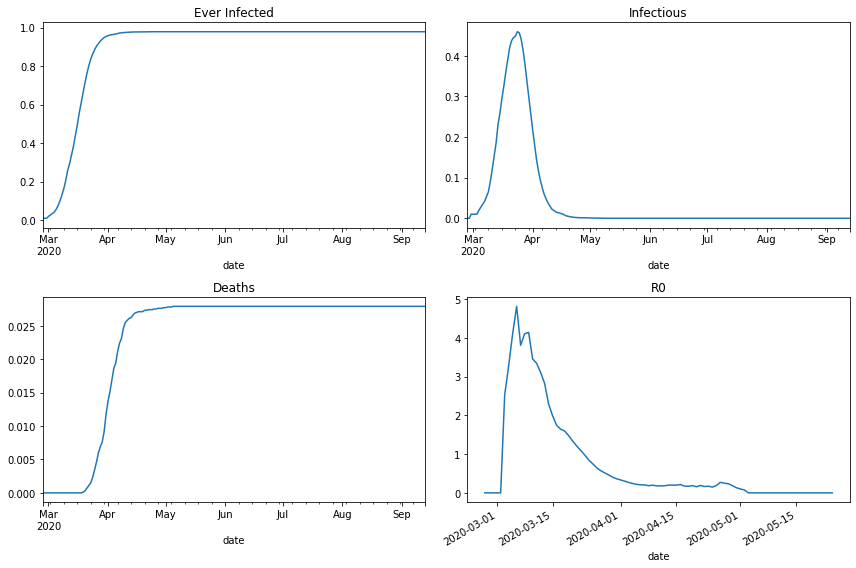

In [392]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.flatten()

df.groupby("date").ever_infected.mean().plot(ax=axs[0])
df.groupby("date").infectious.mean().plot(ax=axs[1])
df.groupby("date").dead.mean().plot(ax=axs[2])

infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].groupby("date").infection_counter.mean().plot(ax=axs[3])

axs[0].set_title("Ever Infected")
axs[1].set_title("Infectious")
axs[2].set_title("Deaths")
axs[3].set_title("R0")


fig.tight_layout()

plt.savefig('output/expl_0.4_0.00_0.4_0.4_0.05_0.05.pdf', format='pdf', dpi=1200)

#inf_params


